필요한 모듈 임포트

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import platform
plt.rc('figure', figsize=(10, 6))  # 그림 크기 설정
if platform.system() == 'Windows': # 윈도우
    from matplotlib import font_manager, rc
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)
elif platform.system() == 'Linux': # 우분투 또는 구글 코랩
    # !sudo apt-get install -y fonts-nanum*
    # !fc-cache -fv
    
    applyfont = "NanumBarunGothic"
    import matplotlib.font_manager as fm
    if not any(map(lambda ft: ft.name == applyfont, fm.fontManager.ttflist)):
        fm.fontManager.addfont("/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
    plt.rc("font", family=applyfont)
    plt.rc("axes", unicode_minus=False)

In [3]:
# GradientBoosting
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [4]:
from sklearn.preprocessing import StandardScaler

데이터 가져오기

In [5]:
base_path = r"C:\Users\owner\Desktop\water-source\data"

In [6]:
jsb_yearly = pd.read_excel(base_path+"\Jugsanbo.xlsx", 
                            skiprows=0, 
                            header=1, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=True)  # index_col = 0을 제외함

In [7]:
print(type(jsb_yearly))  # type-dict
print(jsb_yearly.keys())  # 2012년부터 2022년까지

<class 'dict'>
dict_keys(['2012년', '2013년', '2014년', '2015년', '2016년', '2017년', '2018년', '2019년', '2020년', '2021년', '2022년'])


In [8]:
jsb_yearly['2012년'].columns

Index(['측정일/월', '측정소명', '수온 ℃', '수소이온농도', '전기전도도 μS/cm', '용존산소 mg/L', '탁도 NTU',
       '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥'],
      dtype='object')

2013년 자료부터

In [9]:
jsb_yearly_df13 = pd.DataFrame()

for item in list(jsb_yearly.keys())[1:]:
    jsb_yearly_df13 = pd.concat([jsb_yearly_df13, jsb_yearly[item]])

In [10]:
jsb_yearly_df13 = jsb_yearly_df13.reset_index(drop=True)

결측치 확인

In [11]:
jsb_yearly_df13.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82064 entries, 0 to 82063
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82064 non-null  object 
 1   측정소명         82064 non-null  object 
 2   수온 ℃         71955 non-null  float64
 3   수소이온농도       72092 non-null  float64
 4   전기전도도 μS/cm  72139 non-null  float64
 5   용존산소 mg/L    70998 non-null  float64
 6   탁도 NTU       71312 non-null  float64
 7   총유기탄소 mg/L   66051 non-null  float64
 8   총질소 mg/L     67124 non-null  float64
 9   총인 mg/L      67772 non-null  float64
 10  클로로필-a mg/㎥  69643 non-null  float64
dtypes: float64(9), object(2)
memory usage: 6.9+ MB


In [12]:
jsb_yearly_df13.isnull().sum()

측정일/월              0
측정소명               0
수온 ℃           10109
수소이온농도          9972
전기전도도 μS/cm     9925
용존산소 mg/L      11066
탁도 NTU         10752
총유기탄소 mg/L     16013
총질소 mg/L       14940
총인 mg/L        14292
클로로필-a mg/㎥    12421
dtype: int64

In [13]:
jsb_yearly_df13.head()

,측정일/월,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,탁도 NTU,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥
0,2013-01-01 00h,나주,3.3,6.8,272.0,12.0,1.8,1.9,NaN,NaN,12.2
1,2013-01-01 01h,나주,3.1,6.7,272.0,12.0,1.7,1.9,NaN,NaN,12.0
2,2013-01-01 02h,나주,3.0,6.7,273.0,12.0,1.7,1.9,NaN,NaN,12.1
3,2013-01-01 03h,나주,3.0,6.7,275.0,12.0,1.6,1.9,NaN,NaN,12.2
4,2013-01-01 04h,나주,2.9,6.7,276.0,12.0,1.5,1.9,NaN,NaN,12.1


유량 데이터 추가하기

In [14]:
jsb_flow_yearly = pd.read_excel(base_path+"\Jugsanbo_flow.xlsx", 
                            header=0, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=True)  # index_col = 0을 제외함

In [15]:
for year in list(jsb_flow_yearly.keys())[1:]:
    jsb_flow_yearly[year]['연월일시'] = jsb_flow_yearly[year]['시간'].apply(lambda x : x[:-3])

In [16]:
jsb_flow_yearly_hour = {}

for year in list(jsb_flow_yearly.keys())[1:]:
    jsb_flow_yearly_hour[year] = jsb_flow_yearly[year].groupby('연월일시').mean()

In [17]:
for year in jsb_flow_yearly_hour:
    jsb_flow_yearly_hour[year] = jsb_flow_yearly_hour[year].reset_index()

In [18]:
jsb_flow_yearly_hour_df = pd.DataFrame()

for year in jsb_flow_yearly_hour:
    jsb_flow_yearly_hour_df = pd.concat([jsb_flow_yearly_hour_df, jsb_flow_yearly_hour[year]])

In [19]:
jsb_flow_yearly_hour_df = jsb_flow_yearly_hour_df.reset_index(drop=True)

In [20]:
print(jsb_flow_yearly_hour_df.__len__())
print(jsb_yearly_df13.__len__())

84462
82064


In [21]:
jsb_yearly_df13['연월일시'] = jsb_yearly_df13['측정일/월'].transform(lambda x: x.strip('h').replace('-', '.'))

In [22]:
jsb_data = pd.merge(jsb_yearly_df13, jsb_flow_yearly_hour_df, how='outer')

In [23]:
jsb_data = jsb_data[:82064]

In [24]:
jsb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82064 entries, 0 to 82063
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82064 non-null  object 
 1   측정소명         82064 non-null  object 
 2   수온 ℃         71955 non-null  float64
 3   수소이온농도       72092 non-null  float64
 4   전기전도도 μS/cm  72139 non-null  float64
 5   용존산소 mg/L    70998 non-null  float64
 6   탁도 NTU       71312 non-null  float64
 7   총유기탄소 mg/L   66051 non-null  float64
 8   총질소 mg/L     67124 non-null  float64
 9   총인 mg/L      67772 non-null  float64
 10  클로로필-a mg/㎥  69643 non-null  float64
 11  연월일시         82064 non-null  object 
 12   상류수위(EL.m)  82051 non-null  float64
 13   하류수위(EL.m)  82051 non-null  float64
 14   유입량(㎥/s)    82051 non-null  float64
 15   방류량(㎥/s)    82051 non-null  float64
dtypes: float64(13), object(3)
memory usage: 10.6+ MB


In [25]:
jsb_data.columns = [x.strip() for x in list(jsb_data.columns)]

In [26]:
jsb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82064 entries, 0 to 82063
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82064 non-null  object 
 1   측정소명         82064 non-null  object 
 2   수온 ℃         71955 non-null  float64
 3   수소이온농도       72092 non-null  float64
 4   전기전도도 μS/cm  72139 non-null  float64
 5   용존산소 mg/L    70998 non-null  float64
 6   탁도 NTU       71312 non-null  float64
 7   총유기탄소 mg/L   66051 non-null  float64
 8   총질소 mg/L     67124 non-null  float64
 9   총인 mg/L      67772 non-null  float64
 10  클로로필-a mg/㎥  69643 non-null  float64
 11  연월일시         82064 non-null  object 
 12  상류수위(EL.m)   82051 non-null  float64
 13  하류수위(EL.m)   82051 non-null  float64
 14  유입량(㎥/s)     82051 non-null  float64
 15  방류량(㎥/s)     82051 non-null  float64
dtypes: float64(13), object(3)
memory usage: 10.6+ MB


In [27]:
jsb_data = jsb_data.loc[:, list(jsb_data.columns)[:3]  + list(jsb_data.columns)[4:5] + list(jsb_data.columns)[6:-5] + list(jsb_data.columns)[-4:-3] + list(jsb_data.columns)[-1:]]

In [28]:
jsb_data.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L',
       '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)'],
      dtype='object')

In [29]:
jsb_data.isnull().sum()

측정일/월              0
측정소명               0
수온 ℃           10109
전기전도도 μS/cm     9925
탁도 NTU         10752
총유기탄소 mg/L     16013
총질소 mg/L       14940
총인 mg/L        14292
클로로필-a mg/㎥    12421
상류수위(EL.m)        13
방류량(㎥/s)          13
dtype: int64

In [30]:
jsb_data.isnull().sum() /len(jsb_data)

측정일/월          0.000000
측정소명           0.000000
수온 ℃           0.123184
전기전도도 μS/cm    0.120942
탁도 NTU         0.131020
총유기탄소 mg/L     0.195128
총질소 mg/L       0.182053
총인 mg/L        0.174157
클로로필-a mg/㎥    0.151357
상류수위(EL.m)     0.000158
방류량(㎥/s)       0.000158
dtype: float64

In [31]:
len(jsb_data)

82064

시간데이터 추가

In [32]:
jsb_df = jsb_data.copy()

In [33]:
jsb_df.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L',
       '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)'],
      dtype='object')

In [34]:
col_c = list(jsb_df.columns.copy())
col_c.remove('클로로필-a mg/㎥')

In [35]:
col_c

['측정일/월',
 '측정소명',
 '수온 ℃',
 '전기전도도 μS/cm',
 '탁도 NTU',
 '총유기탄소 mg/L',
 '총질소 mg/L',
 '총인 mg/L',
 '상류수위(EL.m)',
 '방류량(㎥/s)']

In [36]:
for i in range(1, 49):
    jsb_df[str(i) + 'shift 총질소'] = jsb_df['총질소 mg/L'].shift(i)

In [37]:
len(jsb_df)

82064

In [38]:
jsb_df.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L',
       '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)',
       '1shift 총질소', '2shift 총질소', '3shift 총질소', '4shift 총질소', '5shift 총질소',
       '6shift 총질소', '7shift 총질소', '8shift 총질소', '9shift 총질소', '10shift 총질소',
       '11shift 총질소', '12shift 총질소', '13shift 총질소', '14shift 총질소',
       '15shift 총질소', '16shift 총질소', '17shift 총질소', '18shift 총질소',
       '19shift 총질소', '20shift 총질소', '21shift 총질소', '22shift 총질소',
       '23shift 총질소', '24shift 총질소', '25shift 총질소', '26shift 총질소',
       '27shift 총질소', '28shift 총질소', '29shift 총질소', '30shift 총질소',
       '31shift 총질소', '32shift 총질소', '33shift 총질소', '34shift 총질소',
       '35shift 총질소', '36shift 총질소', '37shift 총질소', '38shift 총질소',
       '39shift 총질소', '40shift 총질소', '41shift 총질소', '42shift 총질소',
       '43shift 총질소', '44shift 총질소', '45shift 총질소', '46shift 총질소',
       '47shift 총질소', '48shift 총질소'],
      dtype='object')

In [39]:
len(jsb_df)

82064

결측치 보간법

In [40]:
from datetime import datetime

In [41]:
jsb_df = jsb_df.copy()

In [42]:
jsb_df['측정일/월'] = jsb_df['측정일/월'].transform(lambda x: datetime.strptime(x[:-1], '%Y-%m-%d %H'))

In [43]:
jsb_df = jsb_df.copy().set_index('측정일/월').interpolate(method='time')

In [44]:
jsb_df = jsb_df.dropna()

In [45]:
jsb_df.__len__()

79916

In [46]:
jsb_df.columns

Index(['측정소명', '수온 ℃', '전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L', '총질소 mg/L',
       '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)', '1shift 총질소',
       '2shift 총질소', '3shift 총질소', '4shift 총질소', '5shift 총질소', '6shift 총질소',
       '7shift 총질소', '8shift 총질소', '9shift 총질소', '10shift 총질소', '11shift 총질소',
       '12shift 총질소', '13shift 총질소', '14shift 총질소', '15shift 총질소',
       '16shift 총질소', '17shift 총질소', '18shift 총질소', '19shift 총질소',
       '20shift 총질소', '21shift 총질소', '22shift 총질소', '23shift 총질소',
       '24shift 총질소', '25shift 총질소', '26shift 총질소', '27shift 총질소',
       '28shift 총질소', '29shift 총질소', '30shift 총질소', '31shift 총질소',
       '32shift 총질소', '33shift 총질소', '34shift 총질소', '35shift 총질소',
       '36shift 총질소', '37shift 총질소', '38shift 총질소', '39shift 총질소',
       '40shift 총질소', '41shift 총질소', '42shift 총질소', '43shift 총질소',
       '44shift 총질소', '45shift 총질소', '46shift 총질소', '47shift 총질소',
       '48shift 총질소'],
      dtype='object')

In [47]:
col = list(jsb_df.columns[2:])
print(col)

['전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)', '1shift 총질소', '2shift 총질소', '3shift 총질소', '4shift 총질소', '5shift 총질소', '6shift 총질소', '7shift 총질소', '8shift 총질소', '9shift 총질소', '10shift 총질소', '11shift 총질소', '12shift 총질소', '13shift 총질소', '14shift 총질소', '15shift 총질소', '16shift 총질소', '17shift 총질소', '18shift 총질소', '19shift 총질소', '20shift 총질소', '21shift 총질소', '22shift 총질소', '23shift 총질소', '24shift 총질소', '25shift 총질소', '26shift 총질소', '27shift 총질소', '28shift 총질소', '29shift 총질소', '30shift 총질소', '31shift 총질소', '32shift 총질소', '33shift 총질소', '34shift 총질소', '35shift 총질소', '36shift 총질소', '37shift 총질소', '38shift 총질소', '39shift 총질소', '40shift 총질소', '41shift 총질소', '42shift 총질소', '43shift 총질소', '44shift 총질소', '45shift 총질소', '46shift 총질소', '47shift 총질소', '48shift 총질소']


In [48]:
col_v = col.copy()
col_v.remove('클로로필-a mg/㎥')
print(col_v)

['전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '상류수위(EL.m)', '방류량(㎥/s)', '1shift 총질소', '2shift 총질소', '3shift 총질소', '4shift 총질소', '5shift 총질소', '6shift 총질소', '7shift 총질소', '8shift 총질소', '9shift 총질소', '10shift 총질소', '11shift 총질소', '12shift 총질소', '13shift 총질소', '14shift 총질소', '15shift 총질소', '16shift 총질소', '17shift 총질소', '18shift 총질소', '19shift 총질소', '20shift 총질소', '21shift 총질소', '22shift 총질소', '23shift 총질소', '24shift 총질소', '25shift 총질소', '26shift 총질소', '27shift 총질소', '28shift 총질소', '29shift 총질소', '30shift 총질소', '31shift 총질소', '32shift 총질소', '33shift 총질소', '34shift 총질소', '35shift 총질소', '36shift 총질소', '37shift 총질소', '38shift 총질소', '39shift 총질소', '40shift 총질소', '41shift 총질소', '42shift 총질소', '43shift 총질소', '44shift 총질소', '45shift 총질소', '46shift 총질소', '47shift 총질소', '48shift 총질소']


피처 정규화 없이

In [49]:
X_train, X_test, y_train, y_test = train_test_split(jsb_df.loc[:, col_v], jsb_df['클로로필-a mg/㎥'], random_state=42)
gb_reg = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [50]:
gb_grid = GridSearchCV(gb_reg, param_grid=parameters, cv=3)

In [51]:
gb_grid.fit(X_train, np.log1p(y_train))

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]})

In [52]:
scores_df = pd.DataFrame(gb_grid.cv_results_)

In [53]:
scores_df.sort_values(by=['rank_test_score'], inplace=True)
scores_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.928383,1
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.926924,2
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.923673,3
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.912885,4
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.903791,5


In [54]:
gb_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 15}

In [55]:
estimator = gb_grid.best_estimator_

In [56]:
pred = estimator.predict(X_test)

In [57]:
for score, name in zip(estimator.feature_importances_, col_v):
    print(round(score, 2), name)

0.14 전기전도도 μS/cm
0.09 탁도 NTU
0.19 총유기탄소 mg/L
0.04 총질소 mg/L
0.1 총인 mg/L
0.12 상류수위(EL.m)
0.06 방류량(㎥/s)
0.01 1shift 총질소
0.01 2shift 총질소
0.01 3shift 총질소
0.0 4shift 총질소
0.0 5shift 총질소
0.01 6shift 총질소
0.0 7shift 총질소
0.01 8shift 총질소
0.0 9shift 총질소
0.0 10shift 총질소
0.0 11shift 총질소
0.03 12shift 총질소
0.0 13shift 총질소
0.0 14shift 총질소
0.0 15shift 총질소
0.0 16shift 총질소
0.0 17shift 총질소
0.0 18shift 총질소
0.01 19shift 총질소
0.0 20shift 총질소
0.0 21shift 총질소
0.0 22shift 총질소
0.0 23shift 총질소
0.0 24shift 총질소
0.0 25shift 총질소
0.0 26shift 총질소
0.0 27shift 총질소
0.0 28shift 총질소
0.0 29shift 총질소
0.02 30shift 총질소
0.0 31shift 총질소
0.0 32shift 총질소
0.0 33shift 총질소
0.0 34shift 총질소
0.0 35shift 총질소
0.01 36shift 총질소
0.0 37shift 총질소
0.0 38shift 총질소
0.01 39shift 총질소
0.0 40shift 총질소
0.0 41shift 총질소
0.0 42shift 총질소
0.0 43shift 총질소
0.0 44shift 총질소
0.0 45shift 총질소
0.0 46shift 총질소
0.01 47shift 총질소
0.02 48shift 총질소


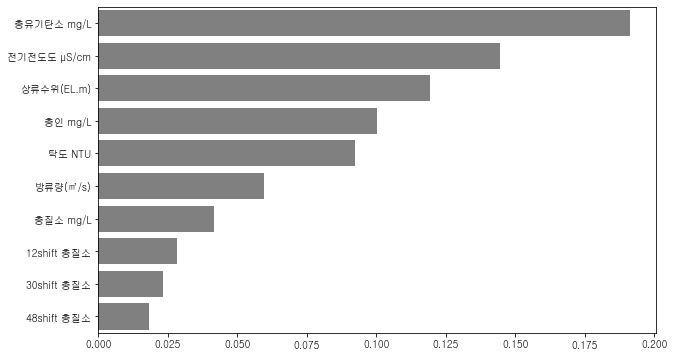

In [58]:
feature_series = pd.Series(data = estimator.feature_importances_, index = col_v)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series[:10], y = feature_series.index[:10], color = 'gray')
plt.show()

In [59]:
print('score :', estimator.score(X_test, np.log1p(y_test)))

score : 0.9462502502160193


In [60]:
feature_series[:10]

총유기탄소 mg/L     0.191151
전기전도도 μS/cm    0.144557
상류수위(EL.m)     0.119473
총인 mg/L        0.100137
탁도 NTU         0.092344
방류량(㎥/s)       0.059707
총질소 mg/L       0.041746
12shift 총질소    0.028515
30shift 총질소    0.023456
48shift 총질소    0.018351
dtype: float64

피처 정규화

In [61]:
scaler = StandardScaler()
scaler.fit(jsb_df.loc[:, col_v])
jsb_scaled = scaler.transform(jsb_df.loc[:, col_v])

jsb_df_scaled = pd.DataFrame(data = jsb_scaled, columns = col_v)

In [62]:
jsb_df_scaled.head()

,전기전도도 μS/cm,탁도 NTU,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,상류수위(EL.m),방류량(㎥/s),1shift 총질소,2shift 총질소,3shift 총질소,...,39shift 총질소,40shift 총질소,41shift 총질소,42shift 총질소,43shift 총질소,44shift 총질소,45shift 총질소,46shift 총질소,47shift 총질소,48shift 총질소
0,-1.199192,-0.209608,-0.556508,-0.438469,1.557523,1.016724,-0.179983,-0.501929,-0.426868,-0.352446,...,-0.520028,-0.441941,-0.438283,-0.512102,-0.480383,-0.513330,-0.530380,-0.518792,-0.555361,-0.522417
1,-1.199192,-0.203691,-0.556508,-0.368309,1.557523,1.019418,-0.178348,-0.438479,-0.501909,-0.426877,...,-0.518198,-0.520030,-0.441943,-0.438284,-0.512107,-0.480386,-0.513298,-0.530383,-0.518759,-0.555359
2,-1.188053,-0.191857,-0.556508,-0.432368,1.537301,1.030193,-0.165745,-0.368318,-0.438460,-0.501919,...,-0.513928,-0.518200,-0.520032,-0.441945,-0.438288,-0.512110,-0.480355,-0.513302,-0.530349,-0.518756
3,-1.176913,-0.197774,-0.556508,-0.487276,1.537301,1.032887,-0.162185,-0.432378,-0.368299,-0.438469,...,-0.485255,-0.513929,-0.518201,-0.520033,-0.441949,-0.438291,-0.512078,-0.480358,-0.513268,-0.530347
4,-1.176913,-0.197774,-0.556508,-0.437859,1.577745,1.032887,-0.162185,-0.487287,-0.432359,-0.368308,...,-0.484035,-0.485256,-0.513931,-0.518203,-0.520038,-0.441952,-0.438261,-0.512081,-0.480326,-0.513266


In [63]:
X_trains, X_tests, y_trains, y_tests = train_test_split(jsb_df_scaled.loc[:, col_v], jsb_df['클로로필-a mg/㎥'], random_state=42)
gb_regs = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [64]:
gb_grids = GridSearchCV(gb_regs, param_grid=parameters, cv=3)

In [65]:
gb_grids.fit(X_trains, np.log1p(y_trains))

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]})

In [66]:
scores_dfs = pd.DataFrame(gb_grids.cv_results_)

In [67]:
scores_dfs.sort_values(by=['rank_test_score'], inplace=True)
scores_dfs[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.928381,1
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.926893,2
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.923677,3
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.912893,4
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.903835,5


In [68]:
gb_grids.best_params_

{'learning_rate': 0.1, 'max_depth': 15}

In [69]:
estimators = gb_grids.best_estimator_

In [70]:
preds = estimators.predict(X_tests)

In [71]:
for score, name in zip(estimators.feature_importances_, col_v):
    print(round(score, 2), name)

0.14 전기전도도 μS/cm
0.09 탁도 NTU
0.19 총유기탄소 mg/L
0.04 총질소 mg/L
0.1 총인 mg/L
0.12 상류수위(EL.m)
0.06 방류량(㎥/s)
0.01 1shift 총질소
0.01 2shift 총질소
0.01 3shift 총질소
0.0 4shift 총질소
0.0 5shift 총질소
0.01 6shift 총질소
0.0 7shift 총질소
0.01 8shift 총질소
0.0 9shift 총질소
0.0 10shift 총질소
0.0 11shift 총질소
0.03 12shift 총질소
0.0 13shift 총질소
0.0 14shift 총질소
0.0 15shift 총질소
0.0 16shift 총질소
0.0 17shift 총질소
0.0 18shift 총질소
0.01 19shift 총질소
0.0 20shift 총질소
0.0 21shift 총질소
0.0 22shift 총질소
0.0 23shift 총질소
0.0 24shift 총질소
0.0 25shift 총질소
0.0 26shift 총질소
0.0 27shift 총질소
0.0 28shift 총질소
0.0 29shift 총질소
0.02 30shift 총질소
0.0 31shift 총질소
0.0 32shift 총질소
0.0 33shift 총질소
0.0 34shift 총질소
0.0 35shift 총질소
0.01 36shift 총질소
0.0 37shift 총질소
0.0 38shift 총질소
0.01 39shift 총질소
0.0 40shift 총질소
0.0 41shift 총질소
0.0 42shift 총질소
0.0 43shift 총질소
0.0 44shift 총질소
0.0 45shift 총질소
0.0 46shift 총질소
0.01 47shift 총질소
0.02 48shift 총질소


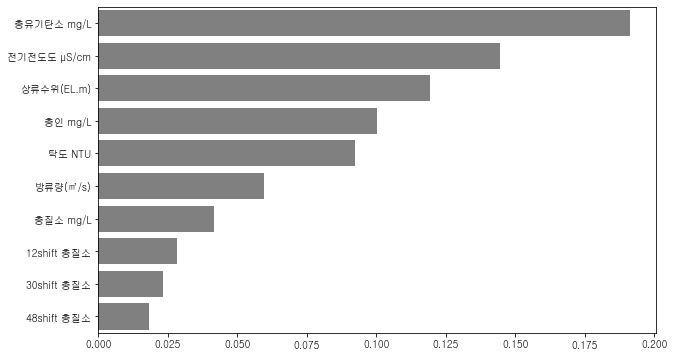

In [72]:
feature_seriess = pd.Series(data = estimators.feature_importances_, index = col_v)
feature_seriess = feature_seriess.sort_values(ascending = False)
sns.barplot(x = feature_seriess[:10], y = feature_seriess.index[:10], color = 'gray')
plt.show()

In [73]:
print('score :', estimators.score(X_tests, np.log1p(y_tests)))

score : 0.946095692753209


In [74]:
feature_series[:10]

총유기탄소 mg/L     0.191151
전기전도도 μS/cm    0.144557
상류수위(EL.m)     0.119473
총인 mg/L        0.100137
탁도 NTU         0.092344
방류량(㎥/s)       0.059707
총질소 mg/L       0.041746
12shift 총질소    0.028515
30shift 총질소    0.023456
48shift 총질소    0.018351
dtype: float64